<h2>Import Libraries</h2><br>
This cell imports all the necessary libraries for data processing, model building, training, and evaluation. It also sets the device to GPU if available.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from tqdm import tqdm

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


<h2>Data Preprocessing</h2><br>
This cell defines the image transformations (resizing and converting to tensors) and loads the training and validation datasets from the specified directories.

In [2]:
# Define the transformations and load the datasets
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Set the paths for the training and validation datasets
train_dataset = datasets.ImageFolder(root=r'C:\Users\dcken\Documents\DPA\brain_tumor\Training', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

val_dataset = datasets.ImageFolder(root=r'C:\Users\dcken\Documents\DPA\brain_tumor\Testing', transform=transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)


<h2>Data Visualization</h2><br>
This cell defines a function to visualize a few images from each class in your training dataset. It then calls this function to display 4 images from each class.

GLIOMA


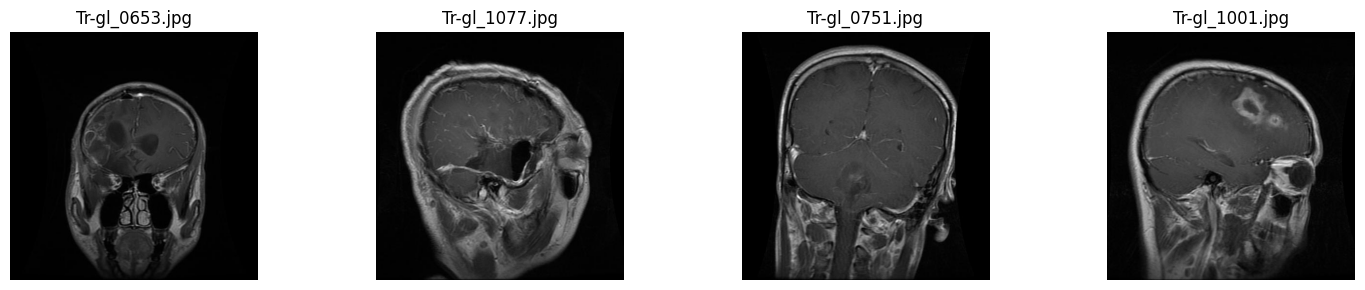

MENINGIOMA


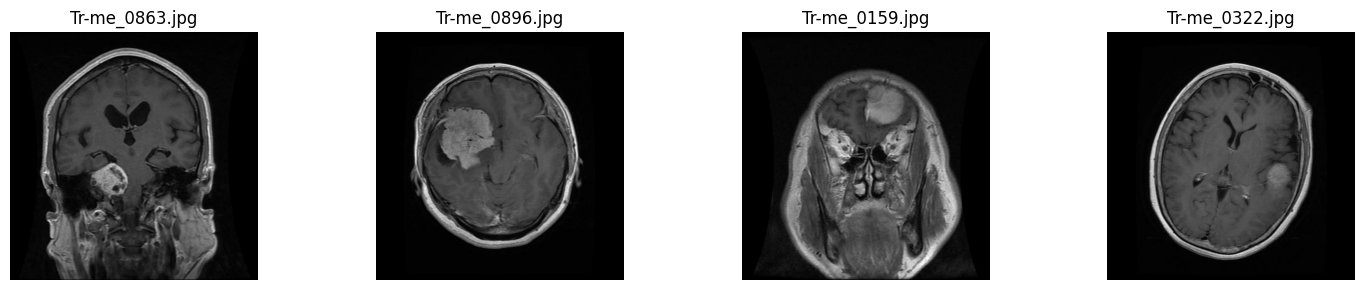

NOTUMOR


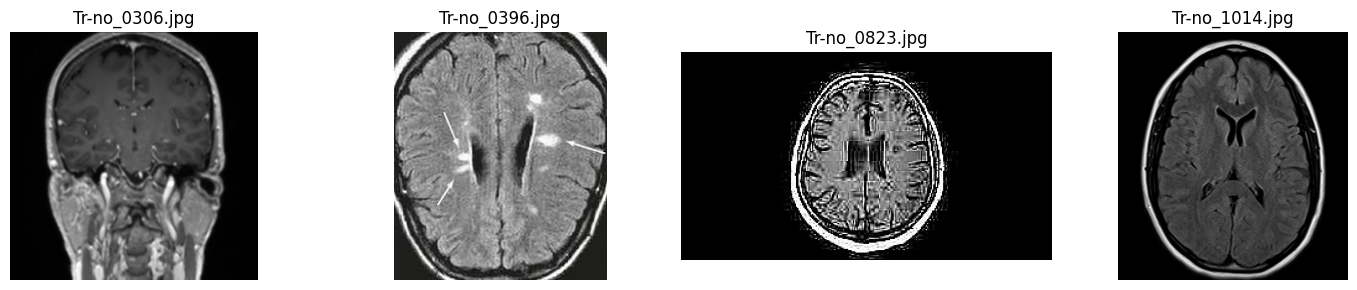

PITUITARY


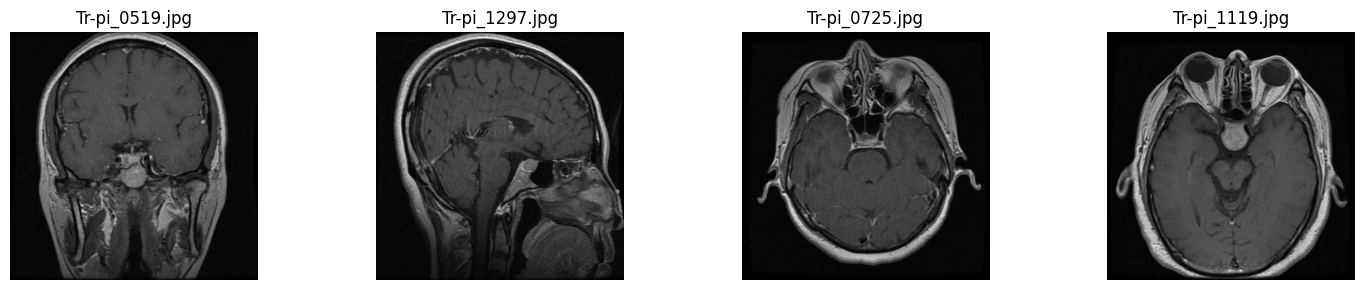

In [3]:
def visualize(path, num_images=5):
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        print("No images found in the specified path")
        return

    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)

        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(image_filename)

    plt.tight_layout()
    plt.show()

classes = train_dataset.classes

for label in classes:
    path_to_viz = fr"C:\Users\dcken\Documents\DPA\brain_tumor\Training\{label}"
    print(label.upper())
    visualize(path_to_viz, num_images=4)


<h2>Load Pre-trained ResNet-50 Model</h2><br>
This cell loads the pre-trained ResNet-50 model from torchvision and modifies the final fully connected layer to match the number of classes in your dataset. The model is then moved to the GPU.

In [4]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Modify the fully connected layer to match the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

model = model.to(device)  # Move the model to the GPU


C:\Users\dcken\anaconda3\envs\project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dcken\anaconda3\envs\project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<h2>Define Loss Function and Optimizer</h2><br>
This cell defines the loss function (CrossEntropyLoss) and the optimizer (Adam) for training the model.

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<h2>Training Loop</h2><br>
This cell contains the training loop, where the model is trained for the specified number of epochs. It tracks and prints the training and validation loss and accuracy at each epoch.

In [10]:
# Training parameters
num_epochs = 20

# To track the training and validation loss and accuracy
training_loss = []
valid_loss = []
training_acc = []
valid_acc = []

# Training loop with progress bar and real-time updates
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0

    # Training loop with progress bar
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)  # Move images and labels to GPU

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

    train_loss /= len(train_loader)
    train_acc = train_acc.double() / len(train_loader.dataset)

    training_loss.append(train_loss)
    training_acc.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move validation data to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)

    val_loss /= len(val_loader)
    val_acc = val_acc.double() / len(val_loader.dataset)

    valid_loss.append(val_loss)
    valid_acc.append(val_acc)

    # Display the current progress of the training
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/20, Training Loss: 0.2145, Training Accuracy: 0.9310, Validation Loss: 0.2308, Validation Accuracy: 0.9130


Epoch 2/20, Training Loss: 0.0448, Training Accuracy: 0.9844, Validation Loss: 0.2089, Validation Accuracy: 0.9390


Epoch 3/20, Training Loss: 0.0247, Training Accuracy: 0.9925, Validation Loss: 0.0982, Validation Accuracy: 0.9703


Epoch 4/20, Training Loss: 0.0086, Training Accuracy: 0.9974, Validation Loss: 0.0831, Validation Accuracy: 0.9748


Epoch 5/20, Training Loss: 0.0057, Training Accuracy: 0.9982, Validation Loss: 0.2157, Validation Accuracy: 0.9321


Epoch 6/20, Training Loss: 0.0247, Training Accuracy: 0.9923, Validation Loss: 0.2579, Validation Accuracy: 0.9291


Epoch 7/20, Training Loss: 0.0231, Training Accuracy: 0.9914, Validation Loss: 0.2121, Validation Accuracy: 0.9375


Epoch 8/20, Training Loss: 0.0200, Training Accuracy: 0.9930, Validation Loss: 0.2052, Validation Accuracy: 0.9458


Epoch 9/20, Training Loss: 0.0070, Training Accuracy: 0.9982, Validation Loss: 0.1649, Validation Accuracy: 0.9641


Epoch 10/20, Training Loss: 0.0072, Training Accuracy: 0.9970, Validation Loss: 0.1207, Validation Accuracy: 0.9680


Epoch 11/20, Training Loss: 0.0092, Training Accuracy: 0.9989, Validation Loss: 0.1347, Validation Accuracy: 0.9687


Epoch 12/20, Training Loss: 0.0910, Training Accuracy: 0.9688, Validation Loss: 0.0811, Validation Accuracy: 0.9748


Epoch 13/20, Training Loss: 0.0226, Training Accuracy: 0.9939, Validation Loss: 0.1298, Validation Accuracy: 0.9649


Epoch 14/20, Training Loss: 0.0205, Training Accuracy: 0.9942, Validation Loss: 0.1683, Validation Accuracy: 0.9603


Epoch 15/20, Training Loss: 0.0132, Training Accuracy: 0.9965, Validation Loss: 0.1800, Validation Accuracy: 0.9580


Epoch 16/20, Training Loss: 0.0056, Training Accuracy: 0.9984, Validation Loss: 0.1394, Validation Accuracy: 0.9664


Epoch 17/20, Training Loss: 0.0018, Training Accuracy: 1.0000, Validation Loss: 0.0699, Validation Accuracy: 0.9802


Epoch 18/20, Training Loss: 0.0026, Training Accuracy: 0.9993, Validation Loss: 0.0830, Validation Accuracy: 0.9802


Epoch 19/20, Training Loss: 0.0025, Training Accuracy: 0.9989, Validation Loss: 0.0667, Validation Accuracy: 0.9825


Epoch 20/20, Training Loss: 0.0023, Training Accuracy: 0.9993, Validation Loss: 0.1372, Validation Accuracy: 0.9695


<h2>Plot Traininf and Validation Metrics</h2><br>
This cell plots the training and validation accuracy and loss over the epochs, allowing you to visualize the model's performance.

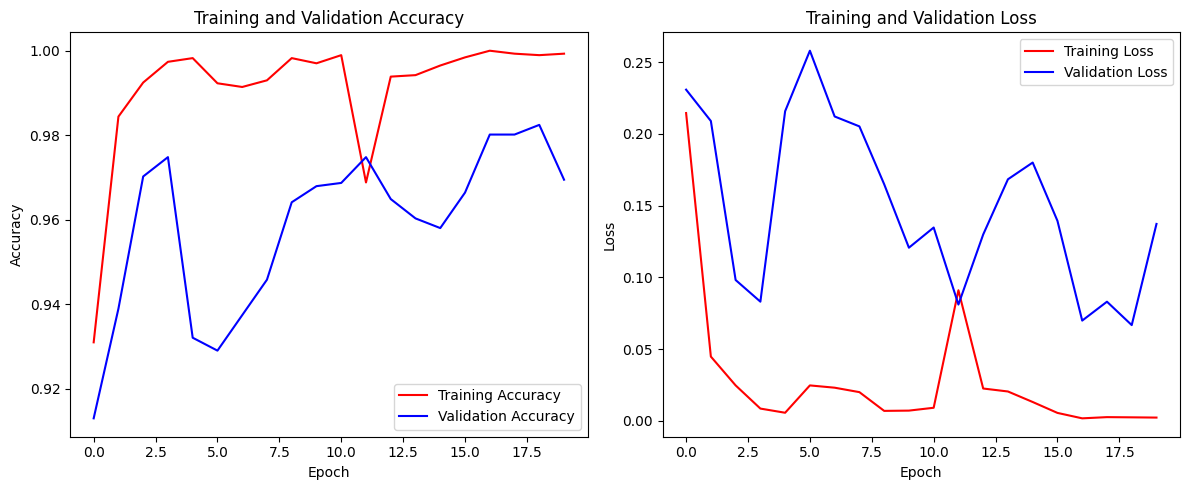

In [11]:
plt.figure(figsize=(12, 5))

training_acc_cpu = [acc.cpu().numpy() for acc in training_acc]
valid_acc_cpu = [acc.cpu().numpy() for acc in valid_acc]

training_loss_cpu = training_loss
valid_loss_cpu = valid_loss

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(training_acc_cpu, color='red', label='Training Accuracy')
plt.plot(valid_acc_cpu, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(training_loss_cpu, color='red', label='Training Loss')
plt.plot(valid_loss_cpu, color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<h2>Evaluate Model with Confusion Matrix</h2><br>
This cell evaluates the model on the validation dataset and generates a confusion matrix to visualize the model's classification performance across different classes.

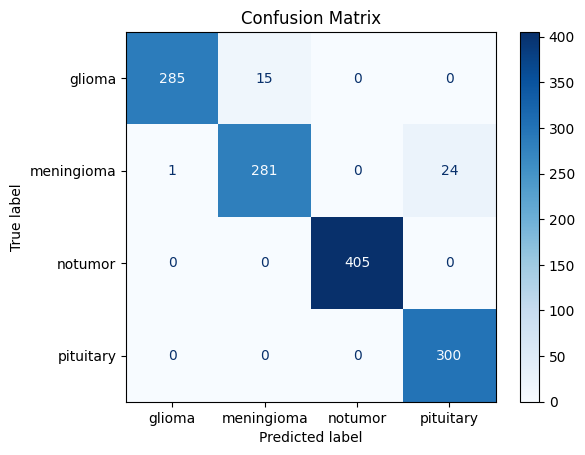

In [12]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


<h2>Save the Model</h2><br>
This cell saves the model in the format that can be used with Flask for the web interface.

In [13]:
torch.save(model.state_dict(), 'model.pth')